In [ ]:
# %cd ..

In [1]:
# type: ignore

import sys
import os
import typing
from typing import cast

import gigaam
from gigaam.model import GigaAMASR
from datasets import Dataset, load_dataset, Audio
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from asr_eval.align.timings import CannotFillTimings
from asr_eval.data import Recording
from asr_eval.models.gigaam import GigaAMEncodeError, encode
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.evaluation import default_evaluation_pipeline, RecordingStreamingEvaluation
from asr_eval.streaming.plots import (
    partial_alignments_plot,
    visualize_history,
    streaming_error_vs_latency_histogram,
    latency_plot,
    show_last_alignments,
)
from asr_eval.serializing import save_to_json, load_from_json

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [4]:
# type: ignore

samples: list[Recording] = []

# name, split = 'mozilla-foundation/common_voice_17_0', 'test'  #, 'ru'
name = 'bond005/podlodka_speech'
for split in ['train', 'validation', 'test']:
    dataset: Dataset = (
        load_dataset(name)[split]
        .cast_column("audio", Audio(sampling_rate=16_000))
        # .rename_column('sentence', 'transcription')
    )

    for i in tqdm(range(len(dataset))):
        try:
            samples.append(Recording.from_sample(
                sample=dataset[i],
                name=name,
                split=split,
                index=i,
                use_gigaam=gigaam_model,
            ))
        except CannotFillTimings:
            pass
        if len(samples) >= 100:
            break

    print(len(samples))

  0%|          | 0/67 [00:00<?, ?it/s]

27


  0%|          | 0/20 [00:00<?, ?it/s]

41


  0%|          | 0/20 [00:00<?, ?it/s]

55


In [5]:
asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=1)
asr.start_thread()

evals: list[RecordingStreamingEvaluation] = []
for recording in tqdm(samples):
    evals.append(default_evaluation_pipeline(recording, asr))
    recording.waveform = None

asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

  0%|          | 0/55 [00:00<?, ?it/s]

Transcribing bond005/podlodka_speech/train/5
Transcribed bond005/podlodka_speech/train/5: потому что поедешь нику клиент уже можно было как-то вот эту пачку [...]
Transcribing bond005/podlodka_speech/train/6
Transcribed bond005/podlodka_speech/train/6: когда у тебя система либо становятся распределённый либо асинхронный [...]
Transcribing bond005/podlodka_speech/train/7
Transcribed bond005/podlodka_speech/train/7: посредственность потерялась и тот же самый клиент может я не знаю там три [...]
Transcribing bond005/podlodka_speech/train/9
Transcribed bond005/podlodka_speech/train/9: слушай вот сейчас в голове крутил кейсы и понял что один у меня совершенно [...]
Transcribing bond005/podlodka_speech/train/15
Transcribed bond005/podlodka_speech/train/15: а не я делал карты а потом я ушёл делать яндекс поиск потом этот яндекс [...]
Transcribing bond005/podlodka_speech/train/18
Transcribed bond005/podlodka_speech/train/18: а большой объем знаний который даётся в интересной форме и из-за этог

In [6]:
save_to_json(evals, 'tmp/evals.json')

In [7]:
evals: list[RecordingStreamingEvaluation] = load_from_json('tmp/evals.json')

In [8]:
eval = evals[-1]

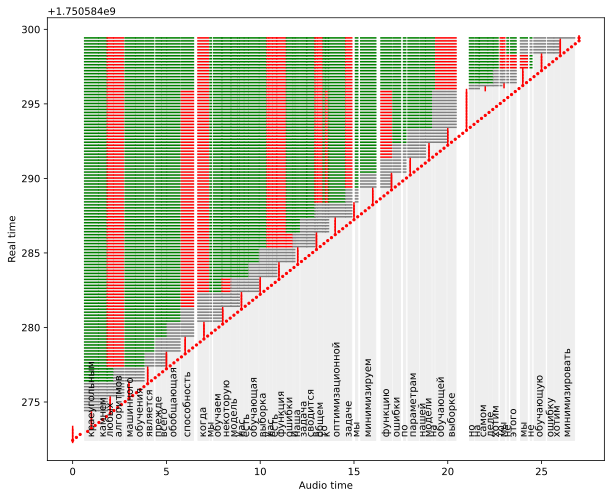

In [9]:
plt.figure(figsize=(10, 8)) # type: ignore
partial_alignments_plot(eval)

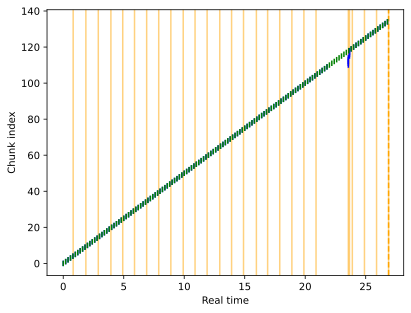

In [10]:
visualize_history(eval.input_chunks, eval.output_chunks)

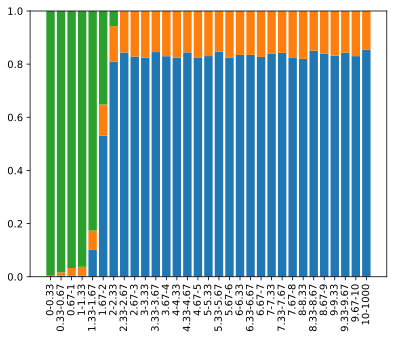

In [11]:
streaming_error_vs_latency_histogram(evals)

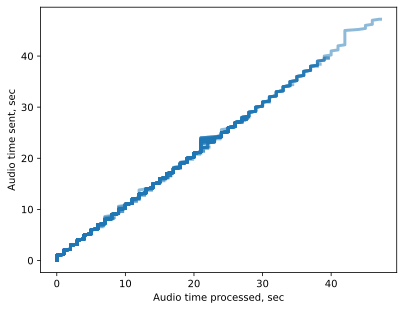

In [12]:
latency_plot(evals)

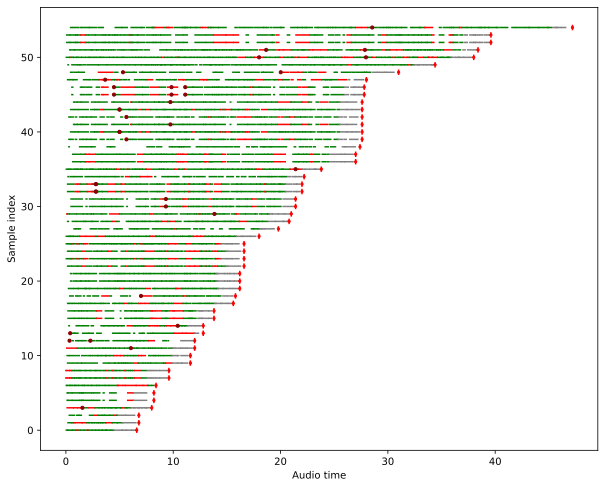

In [13]:
plt.figure(figsize=(10, 8)) # type: ignore
show_last_alignments(evals)